## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
from datetime import date, datetime, timezone, timedelta

exp_day = str(date.today())

KST = timezone(timedelta(hours=9))
time_record = datetime.now(KST)
_day = str(time_record)[:10]
_time = str(time_record.time())[:8]

print(datetime.now(KST))

2022-03-11 14:17:46.204684+09:00


In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import keras

# Root directory of the project
ROOT_DIR = os.path.abspath("../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import utils
import mrcnn.model as modellib
import visualize
from mrcnn.model import log

%matplotlib inline 

import total_seg
import total2_bbox

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

SEG_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_seg.h5")  # epoch 100
BBOX_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_bbox.h5")  # epoch 98

/home/s/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s/anaconda3/envs/maskrcnn/lib/python3.7/site-pack

## Configurations

In [3]:
class SInferenceConfig(total_seg.ParkConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
class BInferenceConfig(total2_bbox.ParkConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


seg_config = SInferenceConfig()
seg_config.display()

bbox_config = BInferenceConfig()
bbox_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
bbox_data_path = 'Dataset2d'

# BBOX 모델 Load Validation Dataset
bbox_dataset = total2_bbox.ParkDataset()
bbox_dataset.load_park(bbox_data_path, "test")
bbox_dataset.prepare()
print("bbox_dataset Images: {}\nClasses: {}".format(len(bbox_dataset.image_ids), bbox_dataset.class_names))

Dataset2d-test/라벨링데이터
Dataset2d-test/원천데이터
6
bbox_dataset Images: 6
Classes: ['BG', 'Car', 'Van', 'Other Vehicle', 'Motorbike', 'Bicycle', 'Electric Scooter', 'Adult', 'Child', 'Stroller', 'Shopping Cart', 'Gate Arm', 'Parking Block', 'Speed Bump', 'Traffic Pole', 'Traffic Cone', 'Traffic Drum', 'Traffic Barricade', 'Cylindrical Bollard', 'U-shaped Bollard', 'Other Road Barriers', 'No Parking Stand', 'Adjustable Parking Pole', 'Waste Tire', 'Planter Barrier', 'Water Container', 'Movable Obstacle', 'Barrier Gate', 'Electric Car Charger', 'Parking Meter', 'Parking Sign', 'Traffic Light', 'Pedestrian Light', 'Street Sign', 'Disabled Parking Space', 'Pregnant Parking Space', 'Electric Car Parking Space', 'Two-wheeled Vehicle Parking Space', 'Other Parking Space']


In [7]:
seg_data_path = 'Dataset2dSeg'

# SEG 모델 Load Validation Dataset
seg_dataset = total_seg.ParkDataset()
seg_dataset.load_park(seg_data_path, "test")
seg_dataset.prepare()
print("seg_dataset Images: {}\nClasses: {}".format(len(seg_dataset.image_ids), seg_dataset.class_names))

Dataset2dSeg-test/라벨링데이터
Dataset2dSeg-test/원천데이터
seg_dataset Images: 9
Classes: ['BG', 'Parking Space', 'Driveable Space']


## Load Model

In [8]:
seg_model = modellib.MaskRCNN(mode="inference", model_dir=SEG_MODEL_PATH, config=seg_config)
bbox_model = modellib.MaskRCNN(mode="inference", model_dir=BBOX_MODEL_PATH, config=bbox_config)

print("Loading seg_weights ", SEG_MODEL_PATH)
seg_model.load_weights(SEG_MODEL_PATH, by_name=True)

print("Loading bbox_weights ", BBOX_MODEL_PATH)
bbox_model.load_weights(BBOX_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading seg_weights  /home/s/dev/Mask_RCNN/mask_rcnn_seg.h5
Loading bbox_weights  /home/s/dev/Mask_RCNN/mask_rcnn_bbox.h5


In [9]:
seg_class_names = ["BG", "Parking Space", "Driveable Space"]

bbox_class_names = ["BG", "Car", "Van", "Other Vehicle", "Motorbike", "Bicycle", "Electric Scooter", "Adult", "Child", "Stroller", "Shopping Cart", "Gate Arm", 
               "Parking Block", "Speed Bump", "Traffic Pole", "Traffic Cone", "Traffic Drum", "Traffic Barricade", "Cylindrical Bollard", "U-shaped Bollard", 
               "Other Road Barriers", "No Parking Stand", "Adjustable Parking Pole", "Waste Tire", "Planter Barrier", "Water Container", "Movable Obstacle", 
               "Barrier Gate", "Electric Car Charger", "Parking Meter", "Parking Sign", "Traffic Light", "Pedestrian Light", "Street Sign", "Disabled Parking Space", 
               "Pregnant Parking Space", "Electric Car Parking Space", "Two-wheeled Vehicle Parking Space", "Other Parking Space"]

## Run Detection(SEG)

image ID: seg.실내_대형주차장_001_00000009.jpg (0) Dataset2dSeg-test/원천데이터/실내_대형주차장_001_00000009.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:    1.00000  max:  854.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


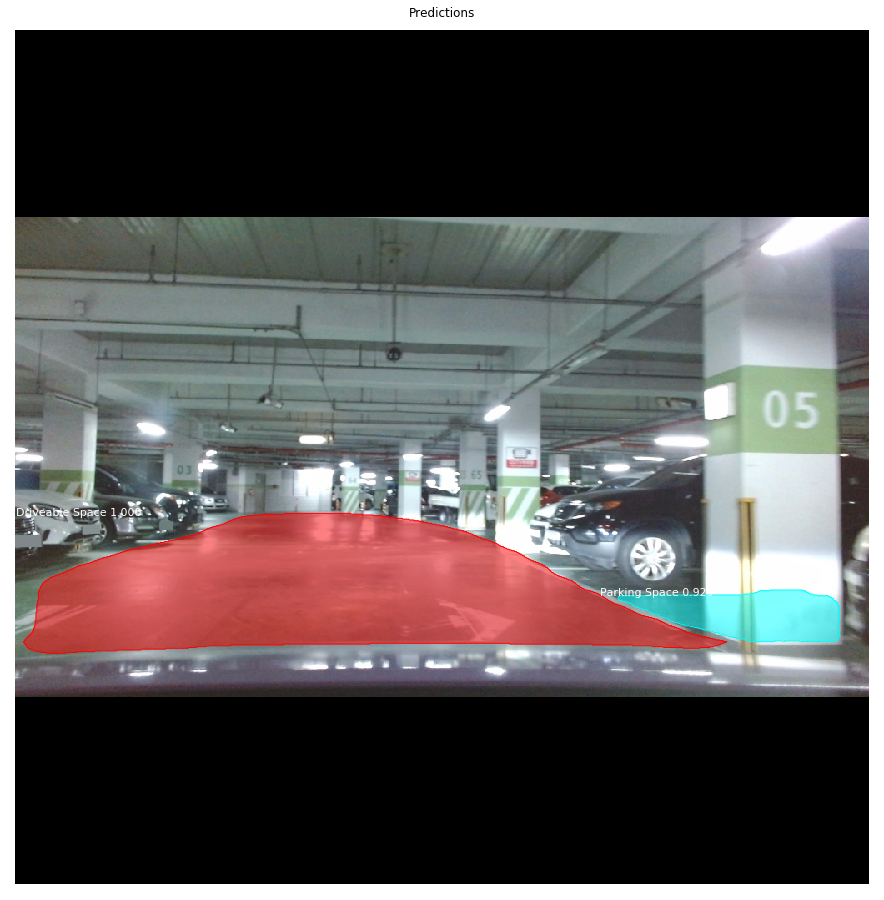

In [10]:
# SEG 모델
import random
image_id = random.choice(seg_dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(seg_dataset, seg_config, image_id, use_mini_mask=False)
info = seg_dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       seg_dataset.image_reference(image_id)))

results = seg_model.detect([image], verbose=1)

# 결과 보기
ax = get_ax(1)
r = results[0]
visualize.display_instances_seg(image, r['rois'], r['masks'], r['class_ids'], 
                            seg_class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall(SEG)

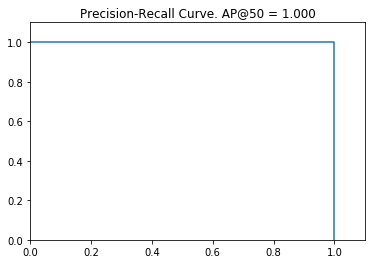

In [11]:
AP, precisions, recalls, overlaps,comp = utils.compute_ap_seg(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

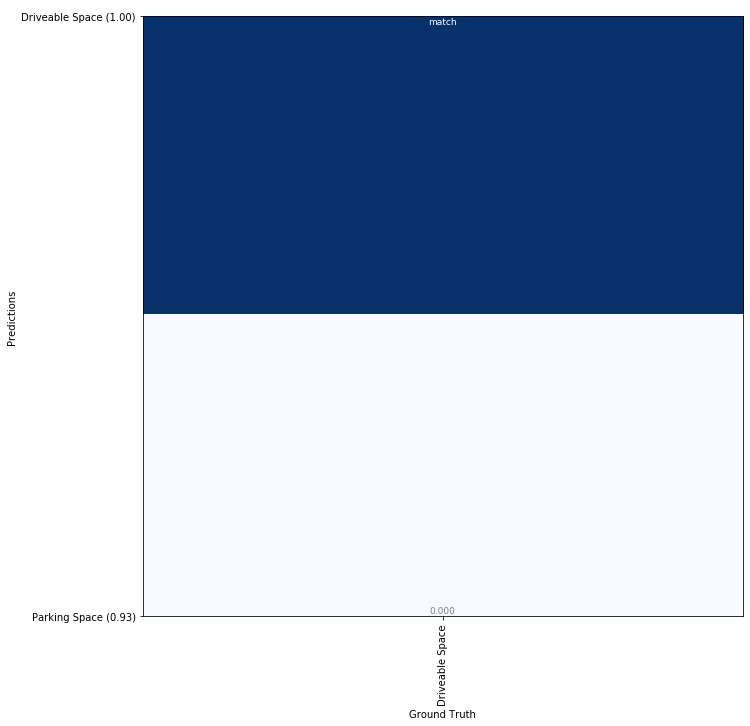

In [12]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, seg_class_names)

## Run Detection(BBOX)

image ID: bbox.실내_대형주차장_001_00000019.jpg (0) Dataset2d-test/원천데이터/실내_대형주차장_001_00000019.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 51)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (15,)                 min:    1.00000  max:   14.00000  int32
gt_bbox                  shape: (15, 4)               min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 15)      min:    0.00000  max:    1.00000  bool


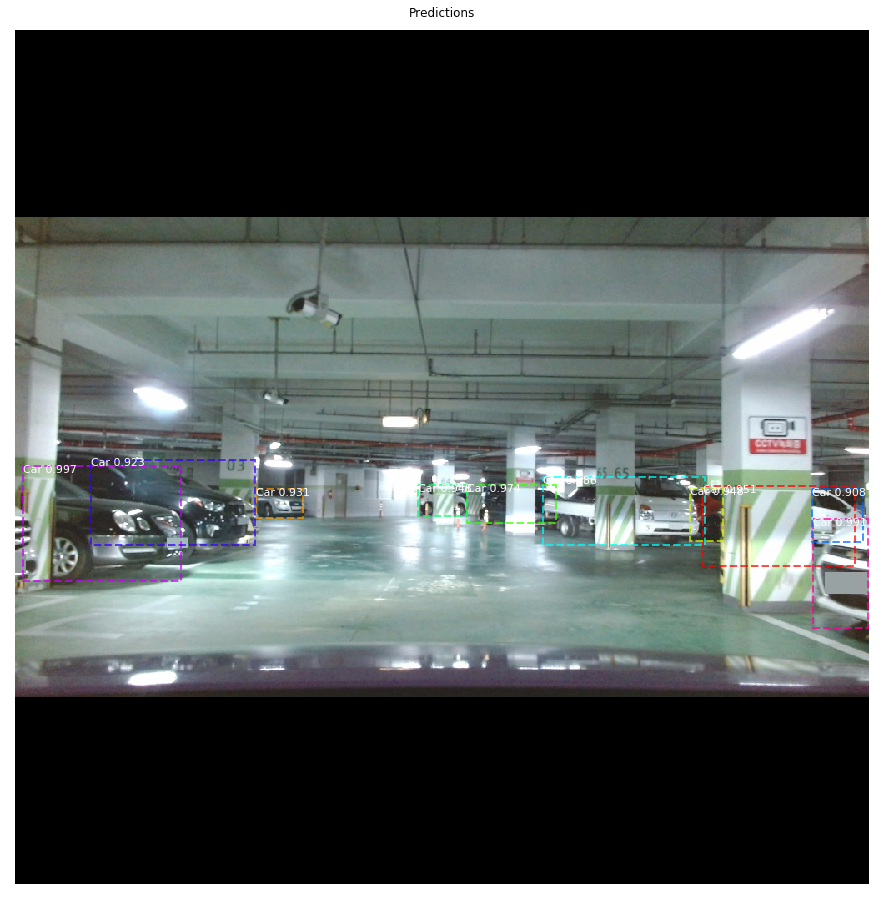

In [13]:
# BBOX 모델
import random
image_id = random.choice(bbox_dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(bbox_dataset, bbox_config, image_id, use_mini_mask=False)
info = bbox_dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       bbox_dataset.image_reference(image_id)))
# Run object detection
results = bbox_model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            bbox_class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall(BBOX)

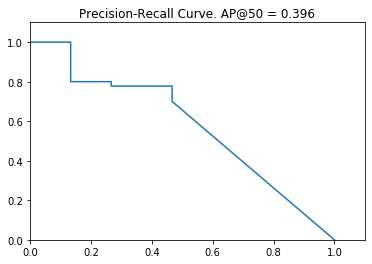

In [14]:
# Draw precision-recall curve

AP, precisions, recalls, overlaps,comp = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

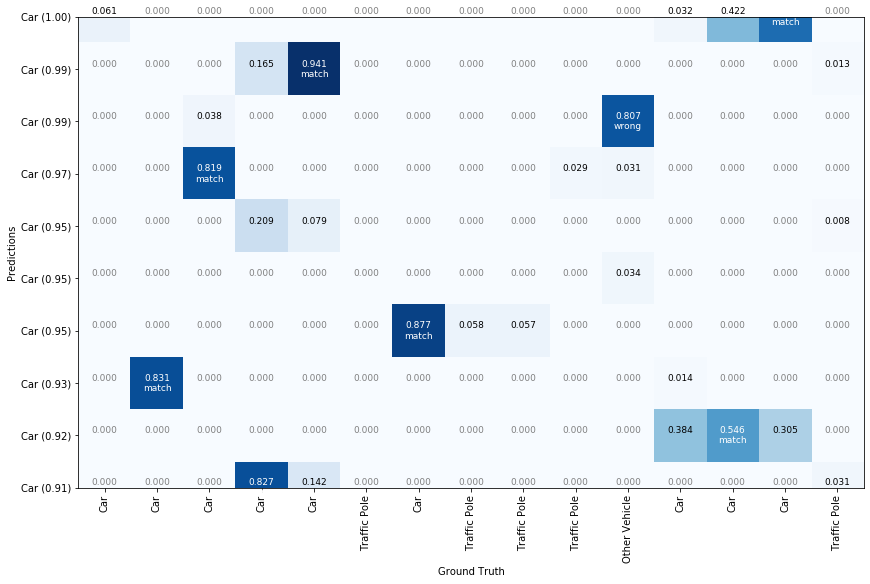

In [15]:
# Grid of ground truth objects and their predictions

visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, bbox_class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [16]:
name_dict_bbox ={
                1 : "Car" ,
                2 : "Van" ,
                3 : "Other Vehicle" , 
                4 : "Motorbike" ,
                5 : "Bicycle",
                6 : "Electric Scooter",
                7 : "Adult",
                8 : "Child",
                9 : "Stroller",
                10 : "Shopping Cart" ,
                11 : "Gate Arm",
                12 : "Parking Block",
                13 : "Speed Bump",
                14 : "Traffic Pole",
                15 : "Traffic Cone",
                16 : "Traffic Drum",
                17 : "Traffic Barricade",
                18 : "Cylindrical Bollard",
                19 : "U-shaped Bollard",
                20 : "Other Road Barriers",
                21 : "No Parking Stand", 
                22 : "Adjustable Parking Pole",
                23 : "Waste Tire",
                24 : "Planter Barrier",
                25 : "Water Container",
                26 : "Movable Obstacle",
                27 : "Barrier Gate",
                28 : "Electric Car Charger",
                29 : "Parking Meter",
                30 : "Parking Sign",
                31 : "Traffic Light",
                32 : "Pedestrian Light",
                33 : "Street Sign",
                34 : "Disabled Parking Space",
                35 : "Pregnant Parking Space",
                36 : "Electric Car Parking Space",
                37 : "Two-wheeled Vehicle Parking Space",
                38 : "Other Parking Space" ,
                }
name_dict_seg ={
                1 : "Parking Space",
                2 : "Driveable Space"
                }

In [17]:
#SEG모델
import csv

image_ids = seg_dataset.image_ids
APs = []

with open('listiou_seg.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    
    for image_id in image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(seg_dataset, seg_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, seg_config), 0)
        results = seg_model.detect([image], verbose=0)
        r = results[0]
        data_name = [seg_dataset.image_reference(image_id)]

        AP, precisions, recalls, overlaps,comp =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        for c in comp :
            c[0] = name_dict_seg[c[0]]
            if len(c) >2:
              c[1] = name_dict_seg[c[1]]
            comp_n = data_name + c
            writer.writerow(comp_n) 
        APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0


In [18]:
#BBOX모델
import csv

image_ids = bbox_dataset.image_ids
APs = []

with open('listiou_bbox.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    
    for image_id in image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(bbox_dataset, bbox_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, bbox_config), 0)
        results = bbox_model.detect([image], verbose=0)
        r = results[0]
        data_name = [bbox_dataset.image_reference(image_id)]

        AP, precisions, recalls, overlaps,comp =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        for c in comp :
            c[0] = name_dict_bbox[c[0]]
            if len(c) >2:
              c[1] = name_dict_bbox[c[1]]
            comp_n = data_name + c
            writer.writerow(comp_n) 
        APs.append(AP)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.4191147044301033
